In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

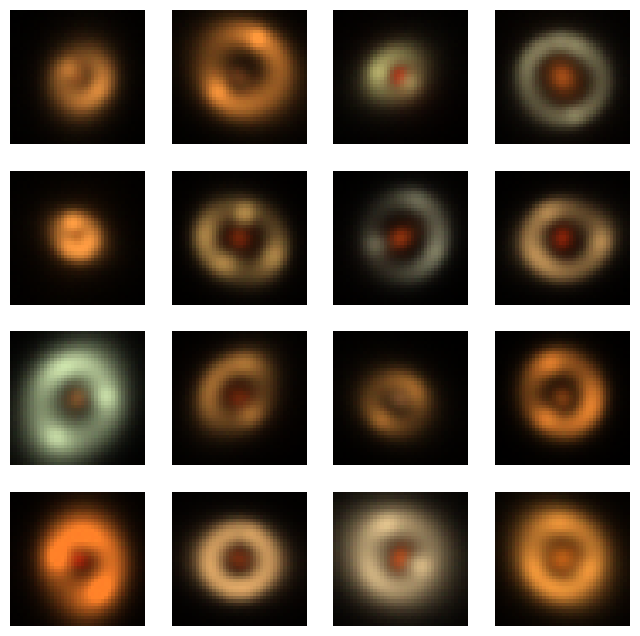

In [4]:
# Visualize source data
visualize_data(source_data)

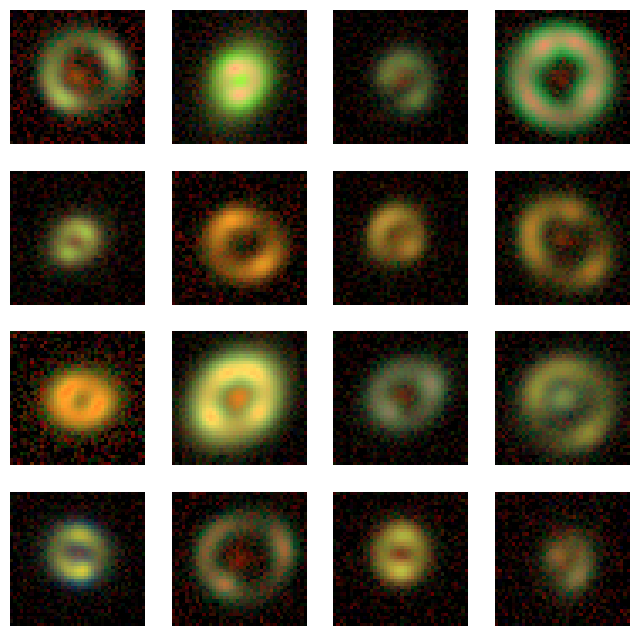

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [8]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    if epoch < evolv_epoch_da:
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / evolv_epoch_da))
    else:
        da_weight = final_wt_da
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch_beta:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch_beta)
    else:
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5

n_epoch = 250
evolv_epoch_beta = 150
evolv_epoch_da = 250

beta_init = 1.0
beta_final = 0.5

init_wt_da = 1.4
final_wt_da = 1.0

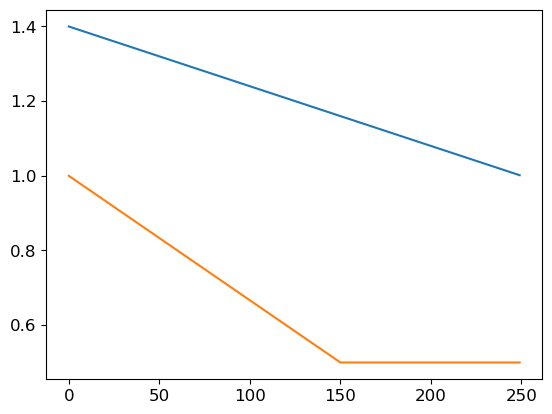

In [9]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

In [10]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = MultiStepLR(optimizer, milestones=[100, 200, 250, 275], gamma=0.5)

In [11]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v3_aug24_1215"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


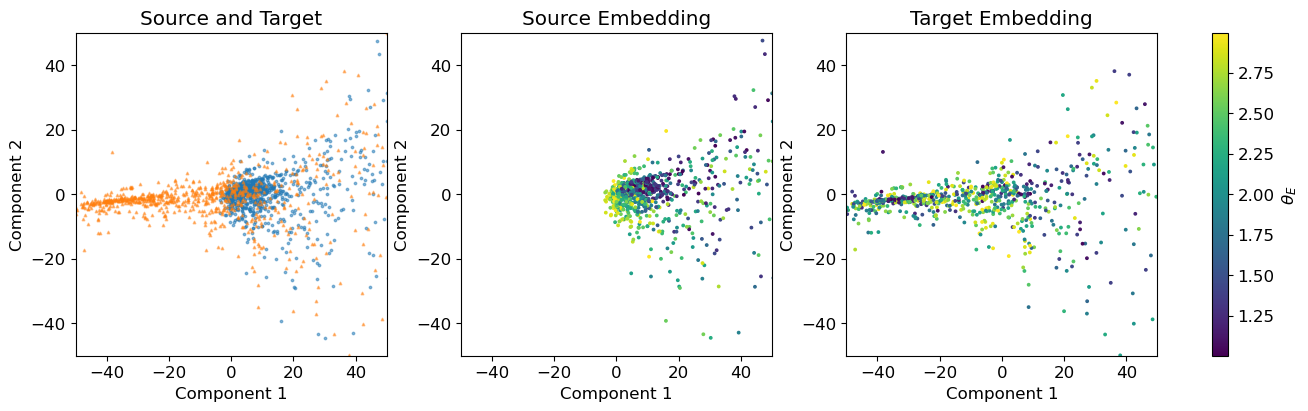


Epoch 0: 33.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4657
	Train Regression Loss: : 2.0740
	Train Mve Loss: : 0.8835
	Train R2 Score: : -5.3215
 Validation Statistics:
	Val Source Regression Loss: : 0.7792
	Val Target Regression Loss: : 0.7237
	Val Source R2 Score: : -1.3843
	Val Target R2 Score: : -1.1479
	Val Source Mve Loss: : 0.2336
	Val Target Mve Loss: : 0.2026
	Val Source Nll Loss: : 0.4683
	Val Target Nll Loss: : 0.4784
Saving Model MVE... Done.
Saving Model NLL... Done.

Epoch 1: 32.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3153
	Train Regression Loss: : 0.4476
	Train Mve Loss: : 0.0647
	Train R2 Score: : -0.3531
 Validation Statistics:
	Val Source Regression Loss: : 0.2847
	Val Target Regression Loss: : 0.2972
	Val Source R2 Score: : 0.1323
	Val Target R2 Score: : 0.1141
	Val Source Mve Loss: : -0.0216
	Val Target Mve Loss: : -0.0199
	Val Source Nll Loss: : -0.0726
	Val Target Nll Loss: : -0.0428
Saving

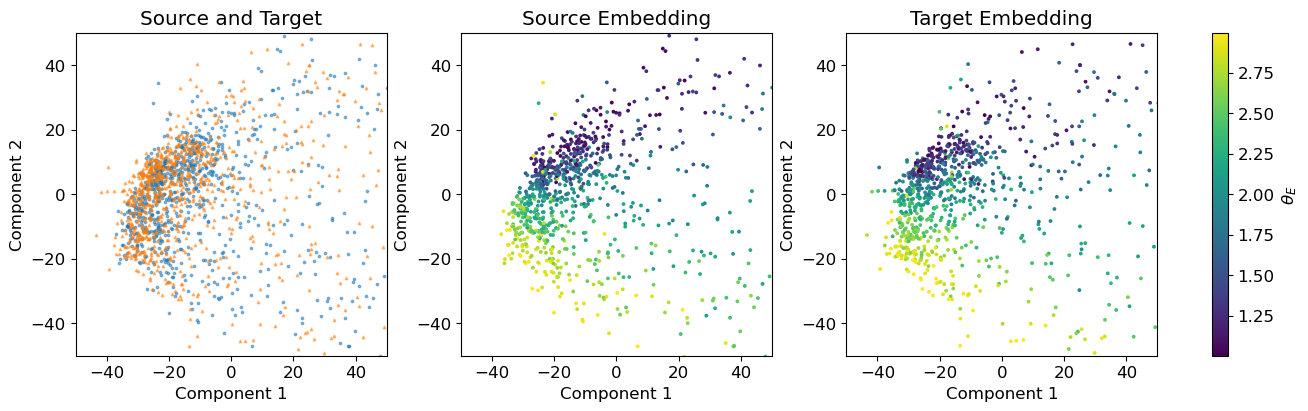

Saving Model... Done.

Epoch 20: 31.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0337
	Train Regression Loss: : 0.0183
	Train Mve Loss: : -0.0615
	Train R2 Score: : 0.9446
 Validation Statistics:
	Val Source Regression Loss: : 0.0185
	Val Target Regression Loss: : 0.0231
	Val Source R2 Score: : 0.9433
	Val Target R2 Score: : 0.9308
	Val Source Mve Loss: : -0.0458
	Val Target Mve Loss: : -0.0427
	Val Source Nll Loss: : 6877.8292
	Val Target Nll Loss: : 8451.7284
Saving Model... Done.

Epoch 21: 33.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0326
	Train Regression Loss: : 0.0179
	Train Mve Loss: : -0.1609
	Train R2 Score: : 0.9458
 Validation Statistics:
	Val Source Regression Loss: : 0.0178
	Val Target Regression Loss: : 0.0237
	Val Source R2 Score: : 0.9454
	Val Target R2 Score: : 0.9296
	Val Source Mve Loss: : -0.1729
	Val Target Mve Loss: : -0.1700
	Val Source Nll Loss: : 72.0048
	Val Target Nll Loss: : 75.4377
Saving

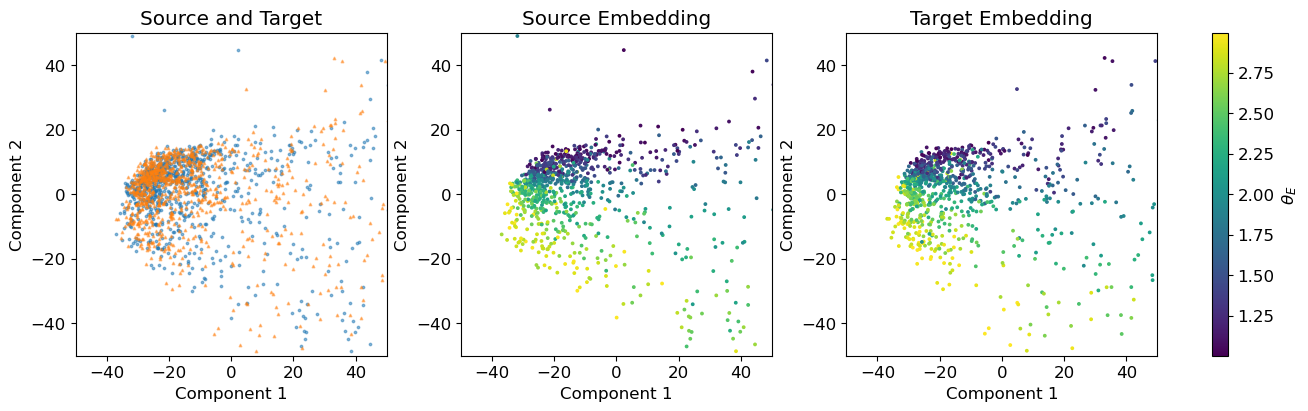


Epoch 40: 32.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0276
	Train Regression Loss: : 0.0133
	Train Mve Loss: : -0.1068
	Train R2 Score: : 0.9597
 Validation Statistics:
	Val Source Regression Loss: : 0.0140
	Val Target Regression Loss: : 0.0189
	Val Source R2 Score: : 0.9570
	Val Target R2 Score: : 0.9439
	Val Source Mve Loss: : -0.0918
	Val Target Mve Loss: : -0.0875
	Val Source Nll Loss: : 1892.8760
	Val Target Nll Loss: : 3206.6732

Epoch 41: 32.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0268
	Train Regression Loss: : 0.0134
	Train Mve Loss: : -0.1701
	Train R2 Score: : 0.9595
 Validation Statistics:
	Val Source Regression Loss: : 0.0135
	Val Target Regression Loss: : 0.0191
	Val Source R2 Score: : 0.9586
	Val Target R2 Score: : 0.9432
	Val Source Mve Loss: : -0.1725
	Val Target Mve Loss: : -0.1695
	Val Source Nll Loss: : 3045.4082
	Val Target Nll Loss: : 3088.1822

Epoch 42: 31.98s
----------------------------

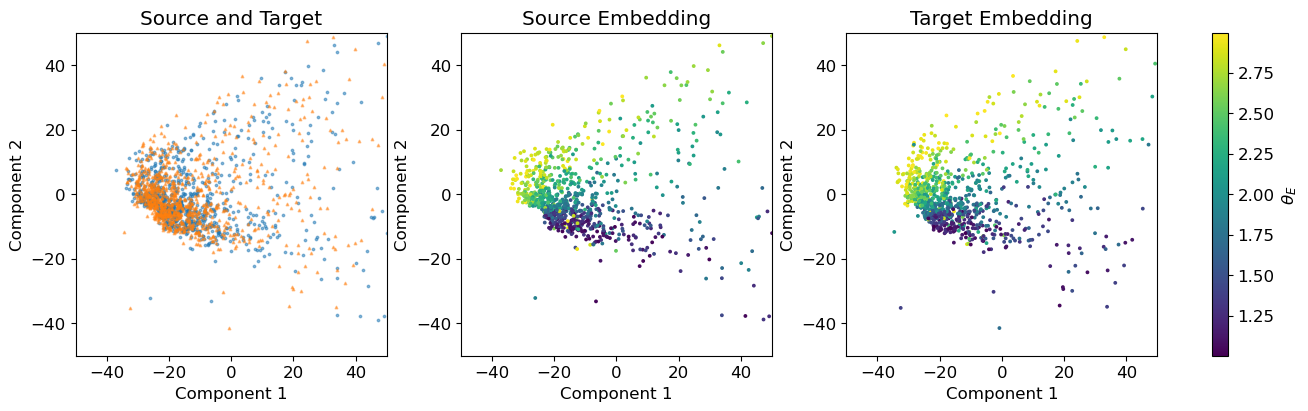


Epoch 60: 31.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0248
	Train Regression Loss: : 0.0121
	Train Mve Loss: : -0.1740
	Train R2 Score: : 0.9634
 Validation Statistics:
	Val Source Regression Loss: : 0.0123
	Val Target Regression Loss: : 0.0177
	Val Source R2 Score: : 0.9624
	Val Target R2 Score: : 0.9472
	Val Source Mve Loss: : -0.1700
	Val Target Mve Loss: : -0.1663
	Val Source Nll Loss: : 3325.3577
	Val Target Nll Loss: : 3787.3743
Saving Model... Done.

Epoch 61: 33.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0248
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.1630
	Train R2 Score: : 0.9631
 Validation Statistics:
	Val Source Regression Loss: : 0.0122
	Val Target Regression Loss: : 0.0184
	Val Source R2 Score: : 0.9626
	Val Target R2 Score: : 0.9453
	Val Source Mve Loss: : -0.1507
	Val Target Mve Loss: : -0.1425
	Val Source Nll Loss: : 4208.8845
	Val Target Nll Loss: : 6120.2308

Epoch 62: 29.53s
------

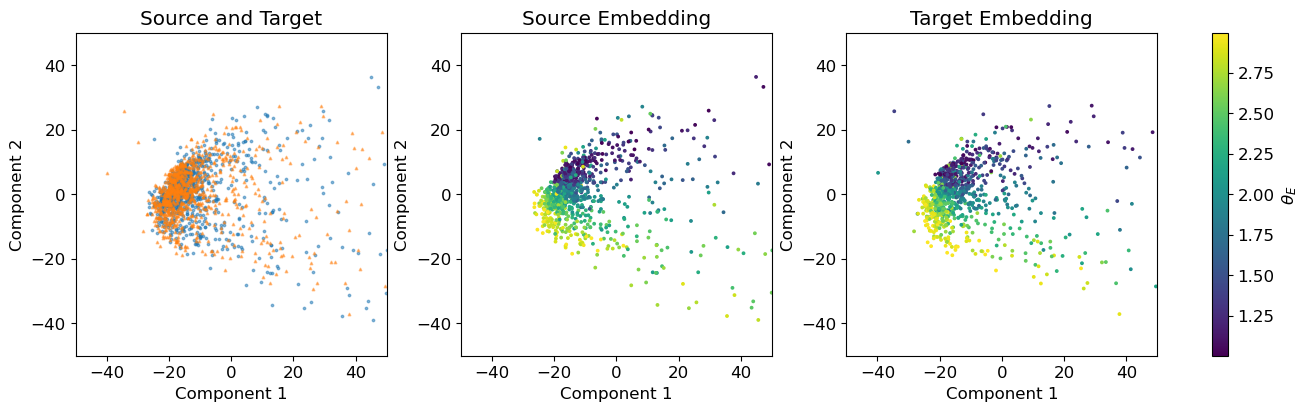


Epoch 80: 32.21s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0219
	Train Regression Loss: : 0.0123
	Train Mve Loss: : -0.1076
	Train R2 Score: : 0.9628
 Validation Statistics:
	Val Source Regression Loss: : 0.0126
	Val Target Regression Loss: : 0.0184
	Val Source R2 Score: : 0.9609
	Val Target R2 Score: : 0.9446
	Val Source Mve Loss: : -0.0675
	Val Target Mve Loss: : -0.0379
	Val Source Nll Loss: : 2622.6670
	Val Target Nll Loss: : 6283.5078

Epoch 81: 31.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0216
	Train Regression Loss: : 0.0121
	Train Mve Loss: : -0.0842
	Train R2 Score: : 0.9634
 Validation Statistics:
	Val Source Regression Loss: : 0.0122
	Val Target Regression Loss: : 0.0180
	Val Source R2 Score: : 0.9623
	Val Target R2 Score: : 0.9469
	Val Source Mve Loss: : -0.0944
	Val Target Mve Loss: : -0.0874
	Val Source Nll Loss: : 1273.0369
	Val Target Nll Loss: : 2179.7451

Epoch 82: 31.09s
----------------------------

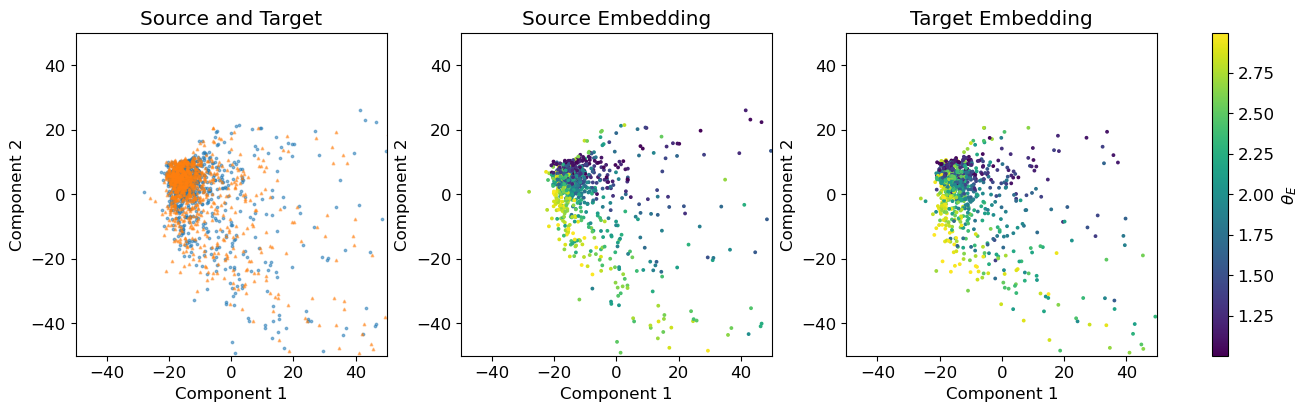


Epoch 100: 34.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0191
	Train Regression Loss: : 0.0125
	Train Mve Loss: : -0.1725
	Train R2 Score: : 0.9621
 Validation Statistics:
	Val Source Regression Loss: : 0.0124
	Val Target Regression Loss: : 0.0170
	Val Source R2 Score: : 0.9619
	Val Target R2 Score: : 0.9494
	Val Source Mve Loss: : -0.1119
	Val Target Mve Loss: : -0.1212
	Val Source Nll Loss: : 1490.6183
	Val Target Nll Loss: : 1444.8276

Epoch 101: 31.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0190
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.1441
	Train R2 Score: : 0.9632
 Validation Statistics:
	Val Source Regression Loss: : 0.0121
	Val Target Regression Loss: : 0.0173
	Val Source R2 Score: : 0.9628
	Val Target R2 Score: : 0.9486
	Val Source Mve Loss: : -0.1480
	Val Target Mve Loss: : -0.1441
	Val Source Nll Loss: : 916.8979
	Val Target Nll Loss: : 1154.6562

Epoch 102: 30.83s
--------------------------

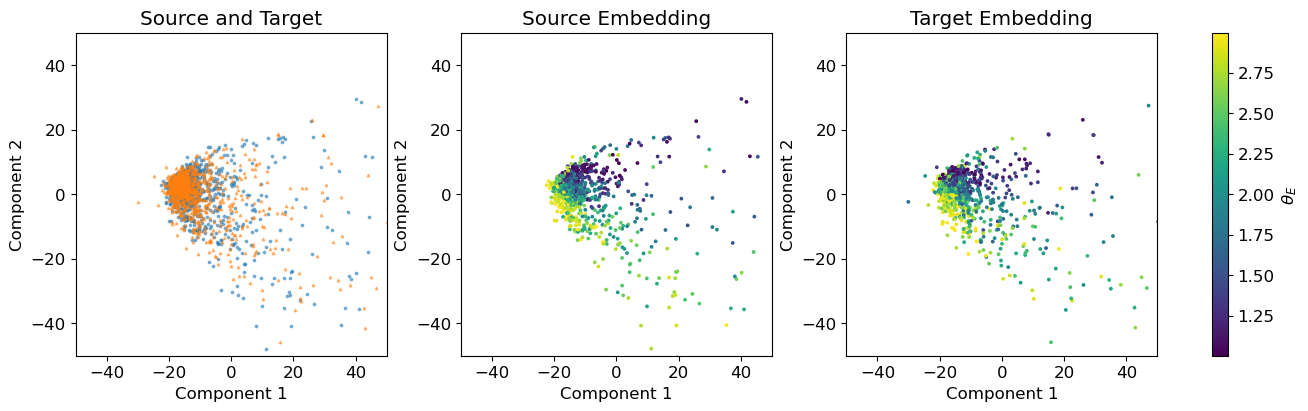


Epoch 120: 34.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0180
	Train Regression Loss: : 0.0118
	Train Mve Loss: : -0.1744
	Train R2 Score: : 0.9641
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.0172
	Val Source R2 Score: : 0.9633
	Val Target R2 Score: : 0.9490
	Val Source Mve Loss: : -0.2026
	Val Target Mve Loss: : -0.2013
	Val Source Nll Loss: : 42.3516
	Val Target Nll Loss: : 49.5141

Epoch 121: 34.49s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0182
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.1729
	Train R2 Score: : 0.9653
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.0168
	Val Source R2 Score: : 0.9646
	Val Target R2 Score: : 0.9499
	Val Source Mve Loss: : -0.1156
	Val Target Mve Loss: : -0.1064
	Val Source Nll Loss: : 822.5902
	Val Target Nll Loss: : 985.8389

Epoch 122: 35.43s
-------------------------------

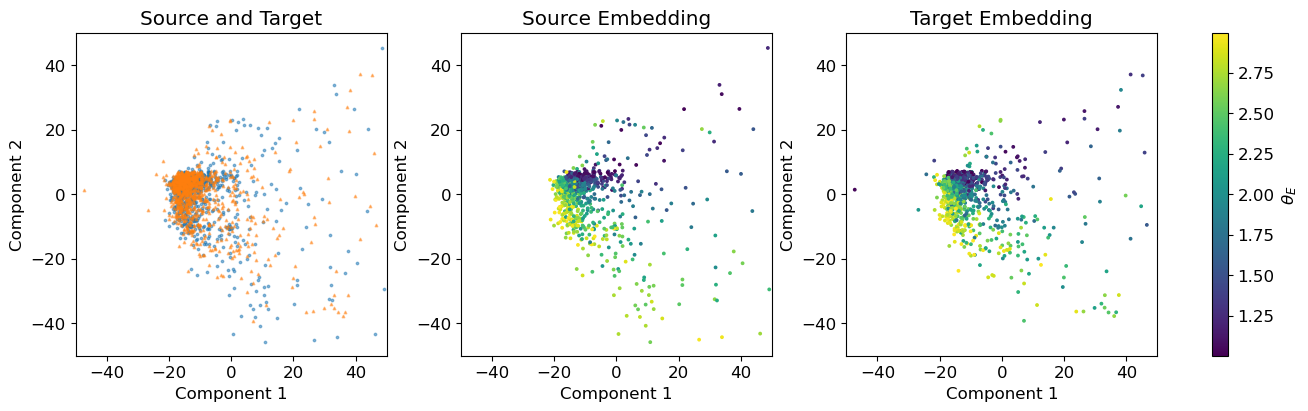


Epoch 140: 35.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0175
	Train Regression Loss: : 0.0100
	Train Mve Loss: : -0.2331
	Train R2 Score: : 0.9696
 Validation Statistics:
	Val Source Regression Loss: : 0.0101
	Val Target Regression Loss: : 0.0151
	Val Source R2 Score: : 0.9687
	Val Target R2 Score: : 0.9487
	Val Source Mve Loss: : -0.0794
	Val Target Mve Loss: : -0.0559
	Val Source Nll Loss: : 1032.9308
	Val Target Nll Loss: : 1131.2372

Epoch 141: 33.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0178
	Train Regression Loss: : 0.0097
	Train Mve Loss: : -0.2699
	Train R2 Score: : 0.9705
 Validation Statistics:
	Val Source Regression Loss: : 0.0099
	Val Target Regression Loss: : 0.0157
	Val Source R2 Score: : 0.9695
	Val Target R2 Score: : 0.9522
	Val Source Mve Loss: : -0.1782
	Val Target Mve Loss: : -0.0892
	Val Source Nll Loss: : 356.4461
	Val Target Nll Loss: : 814.2865

Epoch 142: 31.68s
---------------------------

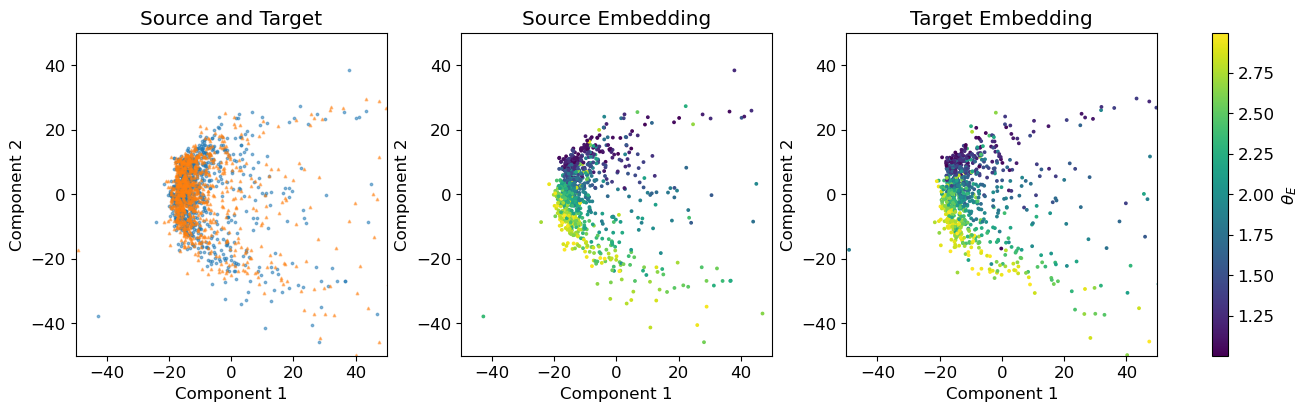


Epoch 160: 32.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0175
	Train Regression Loss: : 0.0102
	Train Mve Loss: : -0.3470
	Train R2 Score: : 0.9690
 Validation Statistics:
	Val Source Regression Loss: : 0.0101
	Val Target Regression Loss: : 0.0145
	Val Source R2 Score: : 0.9692
	Val Target R2 Score: : 0.9564
	Val Source Mve Loss: : -0.3492
	Val Target Mve Loss: : -0.3437
	Val Source Nll Loss: : -0.8343
	Val Target Nll Loss: : -0.8130
Saving Model MVE... Done.

Epoch 161: 31.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0172
	Train Regression Loss: : 0.0101
	Train Mve Loss: : -0.3507
	Train R2 Score: : 0.9694
 Validation Statistics:
	Val Source Regression Loss: : 0.0099
	Val Target Regression Loss: : 0.0153
	Val Source R2 Score: : 0.9696
	Val Target R2 Score: : 0.9546
	Val Source Mve Loss: : -0.3512
	Val Target Mve Loss: : 0.3024
	Val Source Nll Loss: : -0.9524
	Val Target Nll Loss: : 2041.6434

Epoch 162: 30.94s
------

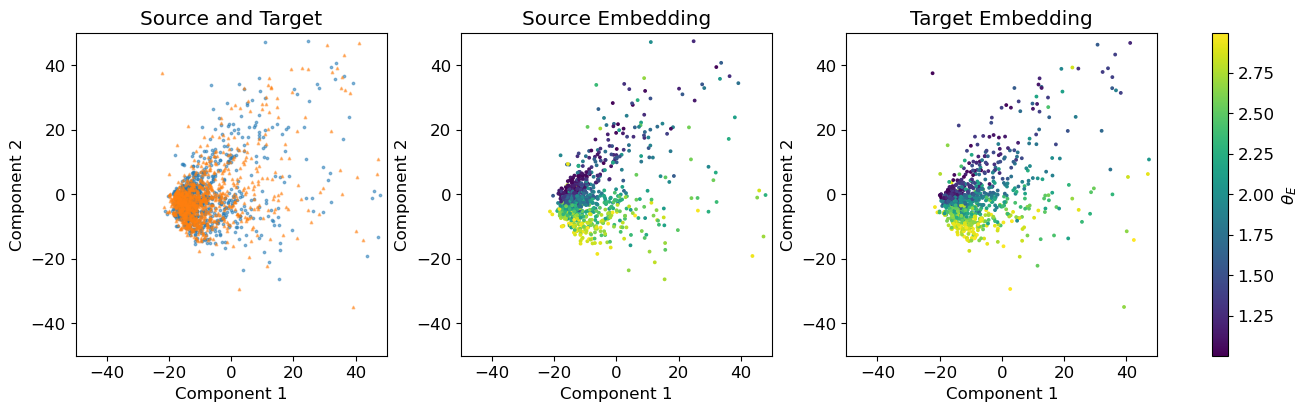


Epoch 180: 32.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0173
	Train Regression Loss: : 0.0093
	Train Mve Loss: : -0.2730
	Train R2 Score: : 0.9719
 Validation Statistics:
	Val Source Regression Loss: : 0.0094
	Val Target Regression Loss: : 0.0155
	Val Source R2 Score: : 0.9714
	Val Target R2 Score: : 0.9533
	Val Source Mve Loss: : -0.3036
	Val Target Mve Loss: : -0.2892
	Val Source Nll Loss: : 78.4570
	Val Target Nll Loss: : 105.3435

Epoch 181: 31.71s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0176
	Train Regression Loss: : 0.0096
	Train Mve Loss: : -0.2903
	Train R2 Score: : 0.9711
 Validation Statistics:
	Val Source Regression Loss: : 0.0106
	Val Target Regression Loss: : 0.0166
	Val Source R2 Score: : 0.9676
	Val Target R2 Score: : 0.9514
	Val Source Mve Loss: : -0.3441
	Val Target Mve Loss: : -0.2256
	Val Source Nll Loss: : 9.7616
	Val Target Nll Loss: : 353.0836

Epoch 182: 32.36s
-------------------------------


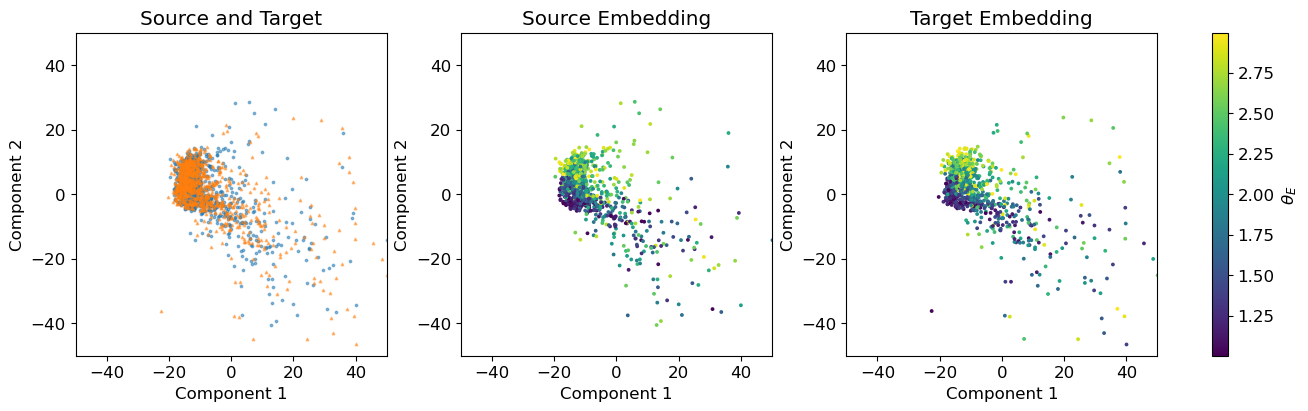


Epoch 200: 31.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0170
	Train Regression Loss: : 0.0090
	Train Mve Loss: : -0.3130
	Train R2 Score: : 0.9726
 Validation Statistics:
	Val Source Regression Loss: : 0.0098
	Val Target Regression Loss: : 0.0198
	Val Source R2 Score: : 0.9702
	Val Target R2 Score: : 0.9409
	Val Source Mve Loss: : -0.3457
	Val Target Mve Loss: : 5.2425
	Val Source Nll Loss: : -0.7233
	Val Target Nll Loss: : 17642.8133

Epoch 201: 31.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0170
	Train Regression Loss: : 0.0093
	Train Mve Loss: : -0.3297
	Train R2 Score: : 0.9718
 Validation Statistics:
	Val Source Regression Loss: : 0.0090
	Val Target Regression Loss: : 0.0165
	Val Source R2 Score: : 0.9726
	Val Target R2 Score: : 0.9512
	Val Source Mve Loss: : -0.2483
	Val Target Mve Loss: : 2.0188
	Val Source Nll Loss: : 278.2015
	Val Target Nll Loss: : 7410.9295

Epoch 202: 30.75s
-----------------------------

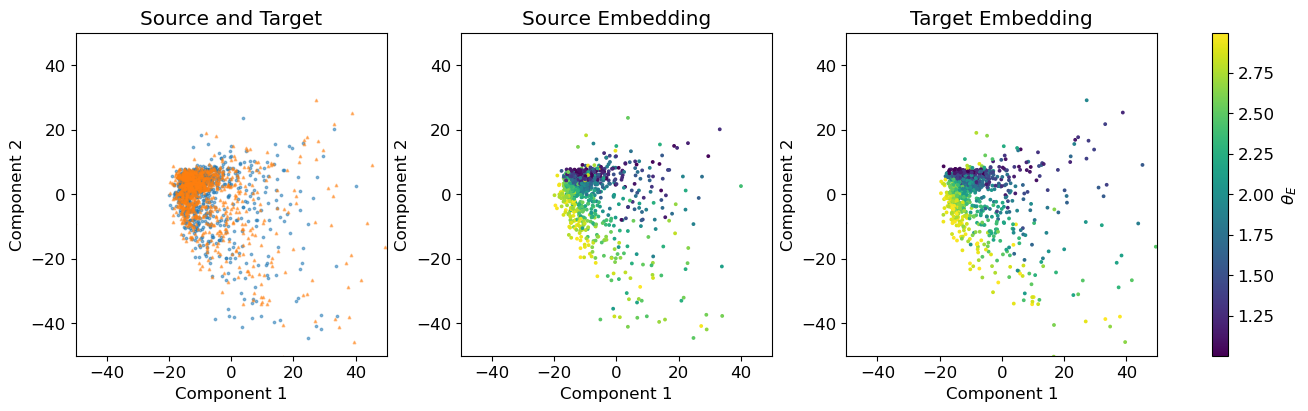


Epoch 220: 32.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0172
	Train Regression Loss: : 0.0106
	Train Mve Loss: : -0.3429
	Train R2 Score: : 0.9681
 Validation Statistics:
	Val Source Regression Loss: : 0.0106
	Val Target Regression Loss: : 0.0210
	Val Source R2 Score: : 0.9675
	Val Target R2 Score: : 0.9370
	Val Source Mve Loss: : -0.3431
	Val Target Mve Loss: : 0.5299
	Val Source Nll Loss: : -0.7511
	Val Target Nll Loss: : 2719.6176

Epoch 221: 35.21s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0180
	Train Regression Loss: : 0.0104
	Train Mve Loss: : -0.3432
	Train R2 Score: : 0.9686
 Validation Statistics:
	Val Source Regression Loss: : 0.0110
	Val Target Regression Loss: : 0.0208
	Val Source R2 Score: : 0.9667
	Val Target R2 Score: : 0.9382
	Val Source Mve Loss: : -0.3426
	Val Target Mve Loss: : 1.1790
	Val Source Nll Loss: : -0.7497
	Val Target Nll Loss: : 4767.6504

Epoch 222: 33.50s
-------------------------------

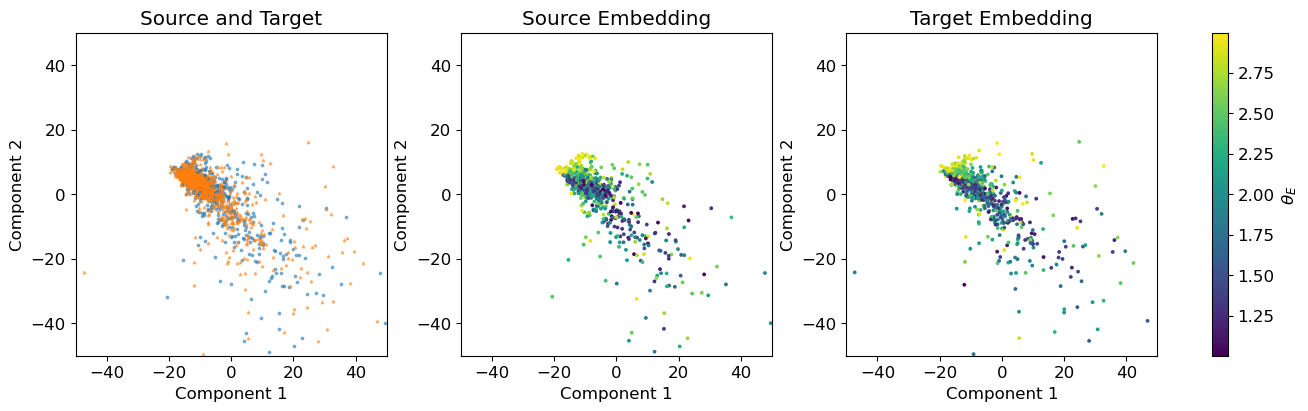


Epoch 240: 34.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0170
	Train Regression Loss: : 0.0088
	Train Mve Loss: : -0.3440
	Train R2 Score: : 0.9733
 Validation Statistics:
	Val Source Regression Loss: : 0.0090
	Val Target Regression Loss: : 0.0202
	Val Source R2 Score: : 0.9726
	Val Target R2 Score: : 0.9364
	Val Source Mve Loss: : -0.3262
	Val Target Mve Loss: : 3.3558
	Val Source Nll Loss: : 81.3766
	Val Target Nll Loss: : 11678.8316

Epoch 241: 33.42s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0178
	Train Regression Loss: : 0.0088
	Train Mve Loss: : -0.3310
	Train R2 Score: : 0.9733
 Validation Statistics:
	Val Source Regression Loss: : 0.0088
	Val Target Regression Loss: : 0.0168
	Val Source R2 Score: : 0.9722
	Val Target R2 Score: : 0.9479
	Val Source Mve Loss: : -0.3230
	Val Target Mve Loss: : 1.3868
	Val Source Nll Loss: : 85.8397
	Val Target Nll Loss: : 5455.8476

Epoch 242: 32.26s
------------------------------

In [12]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        #scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [13]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [28]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

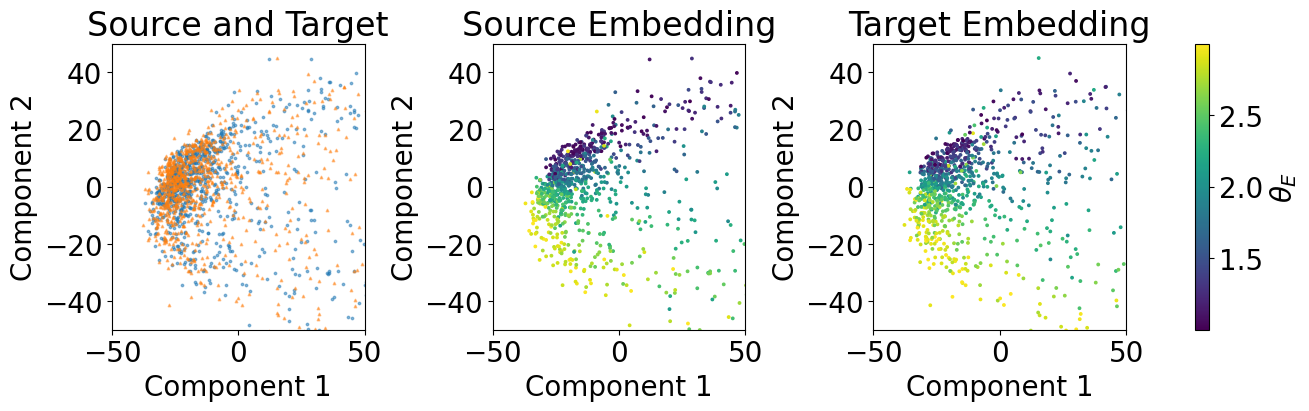

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [29]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

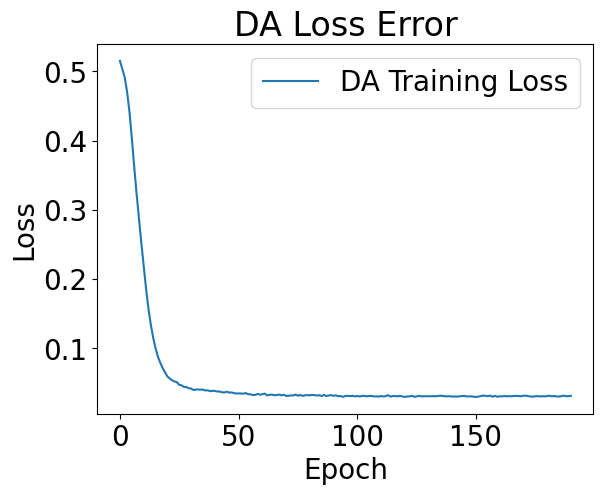

In [30]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

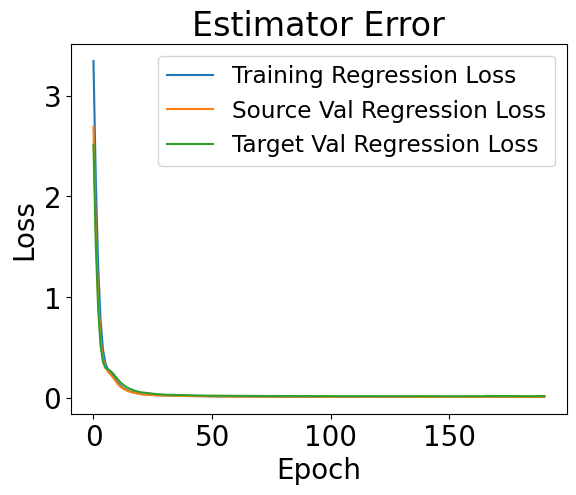

In [31]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

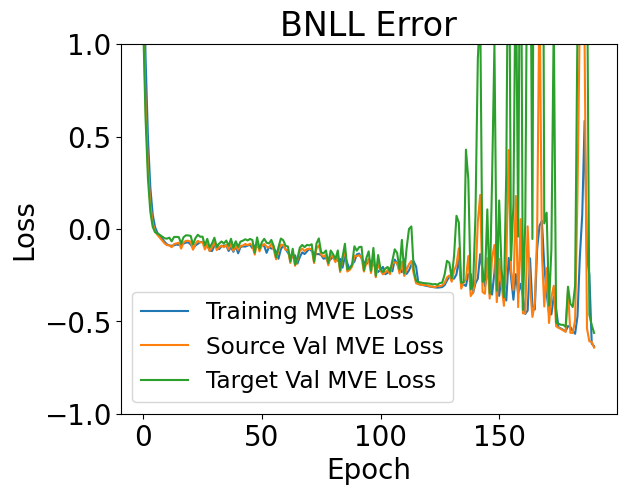

In [32]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

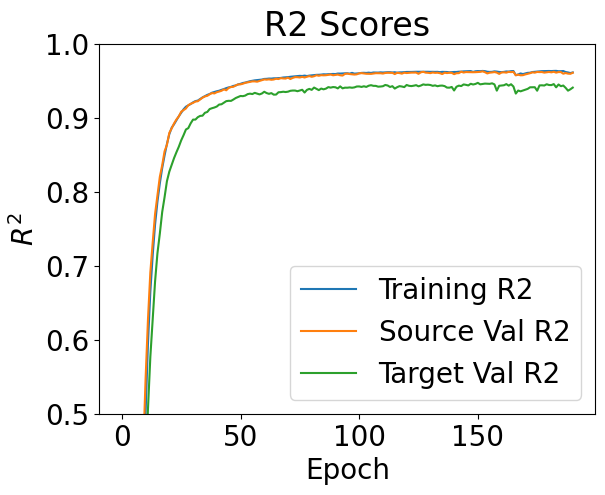

In [33]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [34]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9613


Text(0.5, 1.0, 'MMD | Source | R2: 0.961')

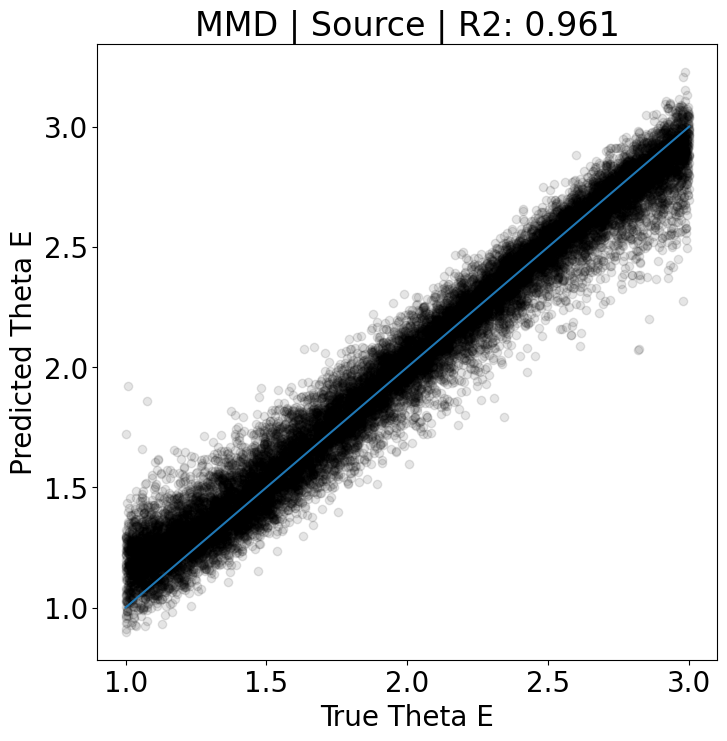

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.308')

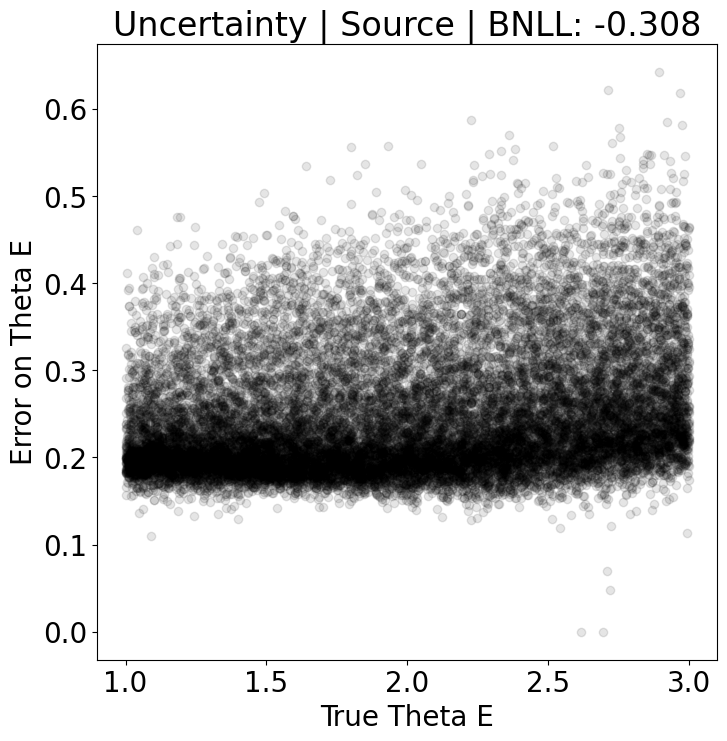

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [37]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9382


Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

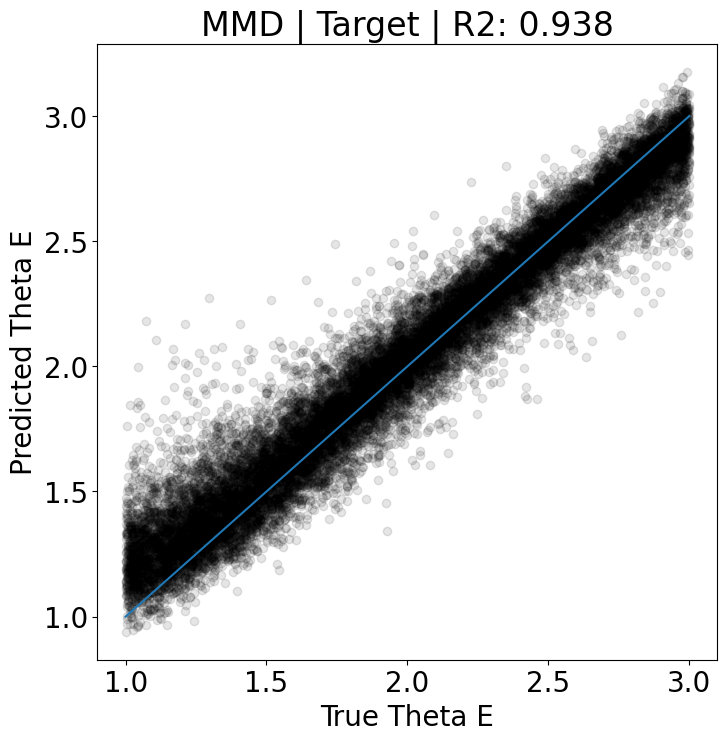

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

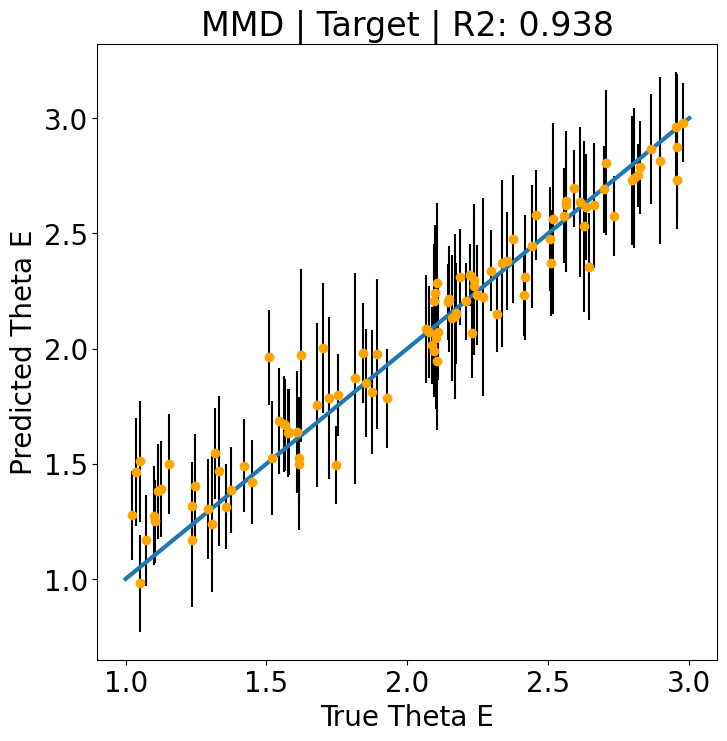

In [39]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.291')

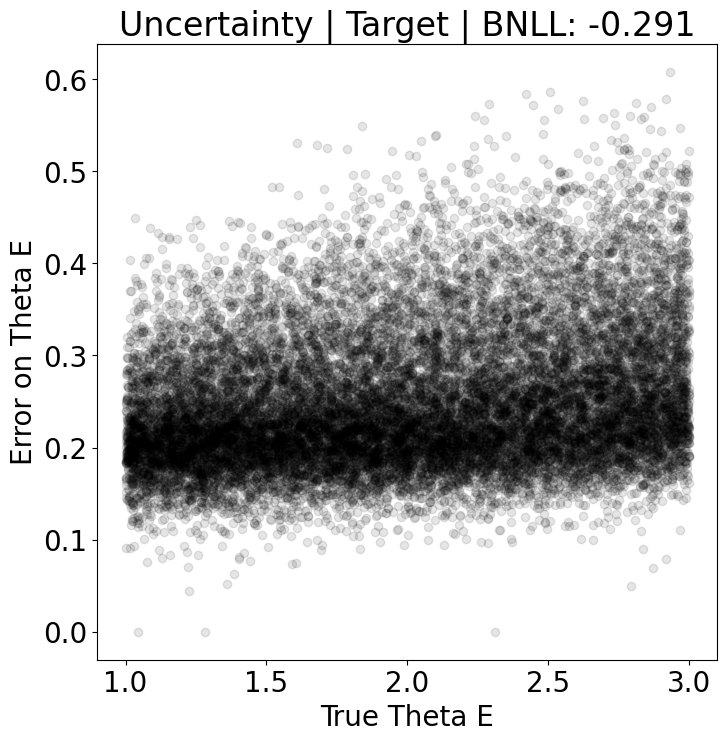

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [41]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

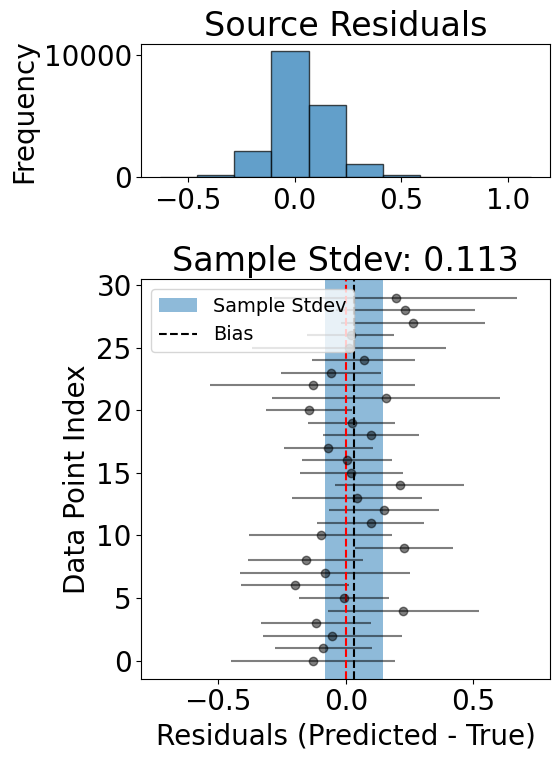

In [42]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

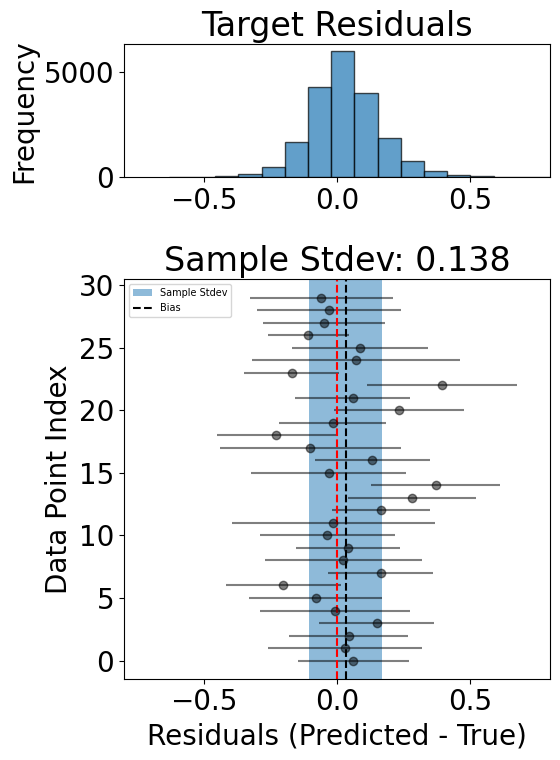

In [43]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()